In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 1.2MB/s 
     |████████████████████████████████| 450kB 47.6MB/s 
     |████████████████████████████████| 3.8MB 31.0MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
# give auth. data is in a public bucket
# so any GCP cloud account will work
from google.colab import auth
auth.authenticate_user()

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
import subprocess
import pickle

import numpy as np
from sklearn.model_selection import ParameterGrid

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

from google.cloud import storage

# os.getcwd
model_folder = "models/"
PRIMARY_BUCKET = "adversarial-finance-resources"

STORAGE_CLIENT = storage.Client(project = 'Adversarial-Finance') # can be any project

def listBucketFiles(bucket_name, prefix=None, delimiter = '/'):
    """Lists all the files in the bucket.
    Call on bucket name with folder as prefix (ending in /)
    Delimiter keeps subfolders from being read, can set to none for a recursive read
    """
    bucket = STORAGE_CLIENT.get_bucket(bucket_name)
    blobs = bucket.list_blobs(prefix=prefix, delimiter=delimiter)
    return ["gs://" + os.path.join(bucket_name,blob.name) for blob in blobs]

def get_data_from_gcs():
    '''Reads training filenames from bucket path for data
    Returns train_list, test_list
    '''

#     train_list = listBucketFiles(PRIMARY_BUCKET, TFRECORD_TRAIN_FOLDER)
#     test_list = listBucketFiles(PRIMARY_BUCKET, TFRECORD_TEST_FOLDER)

#     return train_list, test_list

    # due to some annoying GCP iam issues with giving public users list access to
    # bucket objects, this has to be hard-coded for now
    
    return (['gs://adversarial-finance-resources/data/training/train_data_0.tfrecord'],
             ['gs://adversarial-finance-resources/data/testing/test_data_0.tfrecord'])

def upload_model(model_name, bucket_name = PRIMARY_BUCKET):
    """Uploads a file to the bucket."""
    bucket = STORAGE_CLIENT.get_bucket(bucket_name)
    blob = bucket.blob(model_folder + model_name)
    blob.upload_from_filename(model_name)
    
def enpickle(obj, fn):
    with open(fn, 'wb') as f:
        pickle.dump(obj, f)

def get_dataset(file_list, is_training, batch_size = 128):
    
    def get_fields(data):
        # Define features
        read_features = {

            # features
            'High_scaled_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Low_scaled_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Open_scaled_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Volume_scaled_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            
            'High_scaled_company_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Low_scaled_company_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Open_scaled_company_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Volume_scaled_company_year': tf.io.FixedLenFeature([480], dtype = tf.float32),
            
            'High_scaled_company': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Low_scaled_company': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Open_scaled_company': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'Volume_scaled_company': tf.io.FixedLenFeature([480], dtype = tf.float32),
            'day': tf.io.FixedLenFeature([], dtype = tf.int64),
            'month': tf.io.FixedLenFeature([], dtype = tf.int64),
            
            # label
            'scaled_adj_close': tf.io.FixedLenFeature([8], dtype = tf.float32)
            }
        
        # Extract features from serialized data
        read_data = tf.io.parse_single_example(serialized=data,
                                        features=read_features)   
        
        High_scaled_year = tf.reshape(read_data['High_scaled_year'], (60,8,1))
        Low_scaled_year = tf.reshape(read_data['Low_scaled_year'], (60,8,1))
        Open_scaled_year = tf.reshape(read_data['Open_scaled_year'], (60,8,1))
        Volume_scaled_year = tf.reshape(read_data['Volume_scaled_year'], (60,8,1))
        
        High_scaled_company_year = tf.reshape(read_data['High_scaled_company_year'], (60,8,1))
        Low_scaled_company_year = tf.reshape(read_data['Low_scaled_company_year'], (60,8,1))
        Open_scaled_company_year = tf.reshape(read_data['Open_scaled_company_year'], (60,8,1))
        Volume_scaled_company_year = tf.reshape(read_data['Volume_scaled_company_year'], (60,8,1))
        
        High_scaled_company = tf.reshape(read_data['High_scaled_company'], (60,8,1))
        Low_scaled_company = tf.reshape(read_data['Low_scaled_company'], (60,8,1))
        Open_scaled_company = tf.reshape(read_data['Open_scaled_company'], (60,8,1))
        Volume_scaled_company = tf.reshape(read_data['Volume_scaled_company'], (60,8,1))
        day = tf.one_hot(read_data['day'], 31)
        month = tf.one_hot(read_data['month'], 12)
        target = read_data['scaled_adj_close']
        

        
        feats = {'High_scaled_year': High_scaled_year,
                'Low_scaled_year': Low_scaled_year,
                'Open_scaled_year': Open_scaled_year,
                'Volume_scaled_year': Volume_scaled_year,
                'High_scaled_company_year': High_scaled_company_year,
                'Low_scaled_company_year': Low_scaled_company_year,
                'Open_scaled_company_year': Open_scaled_company_year,
                'Volume_scaled_company_year': Volume_scaled_company_year,
                'High_scaled_company': High_scaled_company,
                'Low_scaled_company': Low_scaled_company,
                'Open_scaled_company': Open_scaled_company,
                'Volume_scaled_company': Volume_scaled_company,
                'day': day,
                'month': month}
        
        return feats, target

        
    dataset = tf.data.TFRecordDataset(filenames=file_list)
    if is_training:
        dataset = dataset.shuffle(500, reshuffle_each_iteration=True).repeat()
    else:
        dataset = dataset.repeat()
    dataset = dataset.map(map_func = get_fields,
            num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(batch_size = batch_size,
    drop_remainder=True)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

def get_model(n_filters = 2, kernal_size = 2, drop_rate = .4,
             n_cn_layers = 1, n_fc_layers = 1, n_fc_nodes = 8,
             activation_type = 'selu', learning_rate = .001, batch_size = None):
    
#     Unlike a standard time series convolutional network,
#     we use a 2D convolution because we want our kernel sliding
#     along 2 dimensions (time and company). We use a 1D kernel
#     because we don't want information adjacent companies to be
#     considered (ie, Microsoft and Nvidia are next to each other
#     in the feature space because they are next to each other
#     alphabetically - we don't want our network seeing patterns
#     in company features relative to other companies).
    
    ts_feats = ['High_scaled_year',
                'Low_scaled_year',
                'Open_scaled_year',
                'Volume_scaled_year',
                'High_scaled_company_year',
                'Low_scaled_company_year',
                'Open_scaled_company_year',
                'Volume_scaled_company_year',
                'High_scaled_company',
                'Low_scaled_company',
                'Open_scaled_company',
                'Volume_scaled_company']

    low_drop = drop_rate
    pred_drop = drop_rate/2
    noise_stdv = 0.001


    if activation_type == 'selu':
        K_INIT = 'lecun_normal'
        DROPOUT_LAYER = layers.AlphaDropout
    else:
        K_INIT = 'glorot_uniform'
        DROPOUT_LAYER = layers.Dropout

#     input_dict = {}
    conv_out_dict = {}

#     for f in ts_feats:
#         input_dict[f] = layers.Input(shape = (60,8, 1), name = f)

    High_scaled_year = layers.Input(shape = (60,8, 1), name = 'High_scaled_year')
    Low_scaled_year = layers.Input(shape = (60,8, 1), name = 'Low_scaled_year')
    Open_scaled_year = layers.Input(shape = (60,8, 1), name = 'Open_scaled_year')
    Volume_scaled_year = layers.Input(shape = (60,8, 1), name = 'Volume_scaled_year')
    High_scaled_company_year = layers.Input(shape = (60,8, 1), name = 'High_scaled_company_year')
    Low_scaled_company_year = layers.Input(shape = (60,8, 1), name = 'Low_scaled_company_year')
    Open_scaled_company_year = layers.Input(shape = (60,8, 1), name = 'Open_scaled_company_year')
    Volume_scaled_company_year = layers.Input(shape = (60,8, 1), name = 'Volume_scaled_company_year')
    High_scaled_company = layers.Input(shape = (60,8, 1), name = 'High_scaled_company')
    Low_scaled_company = layers.Input(shape = (60,8, 1), name = 'Low_scaled_company')
    Open_scaled_company = layers.Input(shape = (60,8, 1), name = 'Open_scaled_company')
    Volume_scaled_company = layers.Input(shape = (60,8, 1), name = 'Volume_scaled_company')

    # month and day one hots
    day = layers.Input(shape = (31,), name = 'day')
    month = layers.Input(shape = (12,), name = 'month')
    
    day_dense_1 = layers.Dense(int(n_fc_nodes/8),
                                 activation=activation_type,
                                 kernel_initializer = K_INIT,
                                 name = "day_dense_1")(day)
    day_drop_1 = DROPOUT_LAYER(low_drop)(day_dense_1)

    month_dense_1 = layers.Dense(int(n_fc_nodes/8),
                                 activation=activation_type,
                                 kernel_initializer = K_INIT,
                                 name = "month_dense_1")(month)
    month_drop_1 = DROPOUT_LAYER(low_drop)(month_dense_1)

    
    for f in ts_feats:
        x = eval(f) # input_dict[f]
        for i in range(n_cn_layers):
            x = layers.Conv2D(filters=n_filters,
                                kernel_size=[kernal_size,1],
                                padding = 'valid',
                                kernel_initializer = K_INIT,
                                activation = activation_type,
                                data_format = 'channels_last',
                                name = f"{f}_conv_{i+1}")(x)
            x = DROPOUT_LAYER(low_drop)(x)


        x = layers.Dense(int(n_fc_nodes/4),
                         activation=activation_type,
                         kernel_initializer = K_INIT,
                         name = f"{f}_dense_pool")(x)
        x = layers.Flatten()(x)
        conv_out_dict[f] = DROPOUT_LAYER(low_drop)(x)


    merged_conv_outs = layers.concatenate([conv_out_dict[f] for f in ts_feats])
    all_merged = layers.concatenate([merged_conv_outs, month_drop_1, day_drop_1])

    for i in range(n_fc_layers):

        all_merged = layers.Dense(n_fc_nodes,
                         activation=activation_type,
                         kernel_initializer = K_INIT,
                         name = f"merged_dense_{i}")(all_merged)
        all_merged = DROPOUT_LAYER(pred_drop)(all_merged)

    pred_prices = layers.Dense(8)(all_merged)

    model = Model(inputs = [High_scaled_year,
                            Low_scaled_year,
                            Open_scaled_year,
                            Volume_scaled_year,
                            High_scaled_company_year,
                            Low_scaled_company_year,
                            Open_scaled_company_year,
                            Volume_scaled_company_year,
                            High_scaled_company,
                            Low_scaled_company,
                            Open_scaled_company,
                            Volume_scaled_company,
                            day,
                            month],
#                   inputs = tuple(input_dict.values()) + (day, month),
                 outputs = pred_prices)
    opt = tf.keras.optimizers.Adam(learning_rate)
    model.compile(loss = 'mse', optimizer = opt)
    return model



In [0]:
train_files, test_files = get_data_from_gcs()

In [0]:
param_grid = {'batch_size': [32, 64, 128],
              'activation_type': ['relu', 'selu'],
              'n_filters':[8, 16, 32],
              'learning_rate':np.logspace(-3, -2, 5, base = 10),
              'kernal_size':[2, 3, 4],
              'drop_rate':np.linspace(.2, .4, 3),
              'n_cn_layers':[1, 2, 3],
              'n_fc_layers':[1, 2, 3],
              'n_fc_nodes':np.logspace(5, 9, 5, base = 2, dtype = int)
             }
param_list = list(ParameterGrid(param_grid))

In [51]:
np.random.seed(42)
hist = [None]*10
hp_hist = {}
for i in range(10):
    
    params = np.random.choice(param_list, replace = False)
    hp_hist[i] = params
    
    print(f"Starting model {i} with the following HP's:\n\n", params)
    
    train_ds = get_dataset(train_files, True, batch_size =params['batch_size'])
    test_ds = get_dataset(test_files, False, batch_size = params['batch_size'])
    model = get_model(**params)
    
    model_name = f"trading_bot_{i}.h5"
    ckpt = tf.keras.callbacks.ModelCheckpoint(model_name,
                                               monitor = 'val_loss',
                                               verbose = 1,
                                               save_best_only = True,
                                               save_weights_only = False,
                                               mode = 'min')

    callbacks = [ckpt]
    
    hist[i] = model.fit(
                train_ds,
                steps_per_epoch= 4755 // params['batch_size'],
                epochs=10,
                validation_data=test_ds,
                validation_steps= 192 // params['batch_size'],
                verbose=1,
                callbacks = callbacks)
    
    print('\nTraining finished -- uploading model \n\n')
    upload_model(model_name)
    
train_hist = {k:v.history for k,v in enumerate(hist)}
enpickle(hp_hist, 'hp_hist.p')
enpickle(train_hist, 'hist.p')

upload_model('hp_hist.p')
upload_model('hist.p')

Starting model 0 with the following HP's:

 {'activation_type': 'selu', 'batch_size': 32, 'drop_rate': 0.4, 'kernal_size': 4, 'learning_rate': 0.0017782794100389228, 'n_cn_layers': 1, 'n_fc_layers': 3, 'n_fc_nodes': 32, 'n_filters': 16}
Train for 148 steps, validate for 6 steps
Epoch 1/10
147/148 [============================>.] - ETA: 0s - loss: 0.3454
Epoch 00001: val_loss improved from inf to 0.19141, saving model to trading_bot_0.h5
148/148 [==============================] - 20s 136ms/step - loss: 0.3432 - val_loss: 0.1914
Epoch 2/10
147/148 [============================>.] - ETA: 0s - loss: 0.0143
Epoch 00002: val_loss improved from 0.19141 to 0.04904, saving model to trading_bot_0.h5
148/148 [==============================] - 15s 104ms/step - loss: 0.0142 - val_loss: 0.0490
Epoch 3/10
147/148 [============================>.] - ETA: 0s - loss: 0.0047
Epoch 00003: val_loss improved from 0.04904 to 0.04461, saving model to trading_bot_0.h5
148/148 [==============================] - 

TypeError: ignored

In [0]:
import matplotlib.pyplot as plt

In [0]:
line1, = plt.plot([1, 2, 3], label="Line 1", linestyle='--')
line2, = plt.plot([3, 2, 1], label="Line 2", linewidth=4)

# Create a legend for the first line.
first_legend = plt.legend(handles=[line1], loc='upper right')

# Add the legend manually to the current Axes.
ax = plt.gca().add_artist(first_legend)

# Create another legend for the second line.
plt.legend(handles=lines, loc='upper right')

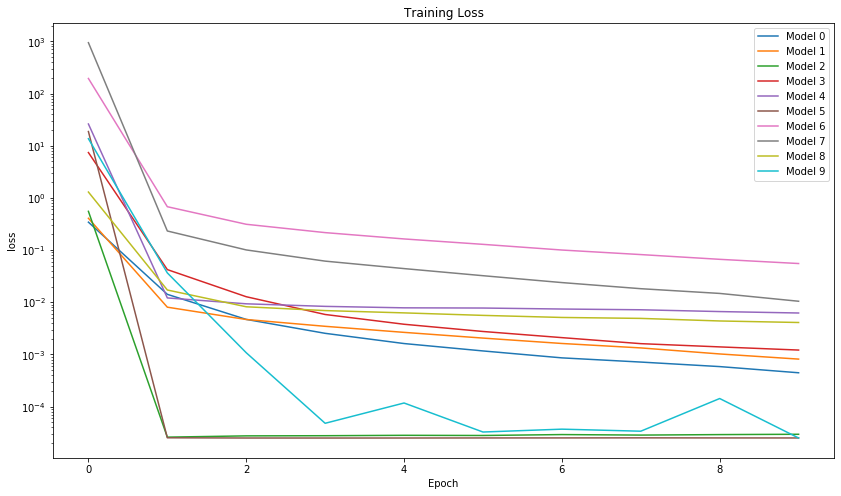

In [77]:
lines = [None]*10
plt.figure(figsize = (14,8))
for i in range(10):
    lines[i], = plt.plot(train_hist[i]['loss'], label = f"Model {i}")
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('Training Loss')
plt.legend(handles=lines, loc='upper right')
plt.savefig('training.png')

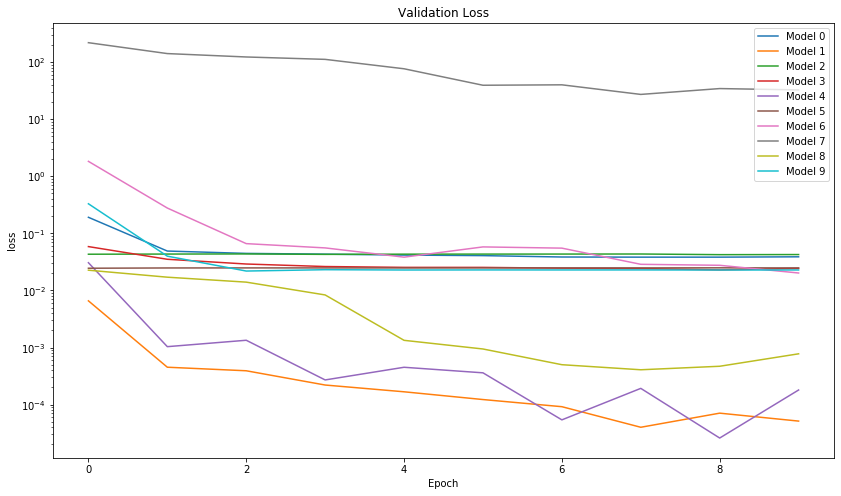

In [78]:
lines = [None]*10
plt.figure(figsize = (14,8))
for i in range(10):
    lines[i], = plt.plot(train_hist[i]['val_loss'], label = f"Model {i}")
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.title('Validation Loss')
plt.legend(handles=lines, loc='upper right')
plt.savefig('validation.png')

In [0]:
model.summary()

In [0]:
tf.keras.utils.plot_model(model, show_shapes = True)